# 02.1b: Orthographic Projections - Spike Colored

**Goal:** Same as 02.1a, but color tokens by **spike membership** instead of depth.

This will reveal whether the mysterious "jet" structure we see in PC4×5×6 space is actually the initialization fossil spike tokens!

We'll:
1. Load spike token IDs from our previous analysis
2. Create spike mask
3. Color spike tokens RED and bulk tokens BLUE in the projections

If the jet **is** the spike, it'll light up red!

## Parameters

In [43]:
TENSOR_DIR = "../data/tensors"
RESULTS_DIR = "../data/results"
POINT_SIZE = 1.0
POINT_ALPHA = 0.1
DPI = 100

# Colors for spike vs bulk
SPIKE_COLOR = 'red'
BULK_COLOR = 'blue'

# Which PCs to visualize (1-indexed, like PC1, PC2, PC3, ...)
# Try different combinations to explore the cloud:
#   1, 2, 3     - Default (highest variance directions)
#   4, 5, 6     - Where we saw the mysterious jet!
#   1279, 1280, 1281  - Middle of spectrum
#   2558, 2559, 2560  - Lowest variance directions
INDEX_X = 1
INDEX_Y = 2
INDEX_Z = 3

## Imports

In [44]:
import torch
import pandas as pd
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Centered Gamma

In [45]:
gamma_centered_path = Path(TENSOR_DIR) / "gamma_centered_qwen3_4b_instruct_2507.safetensors"
gamma_centered = load_file(gamma_centered_path)['gamma_centered']

N, d = gamma_centered.shape

print(f"Loaded γ' (gamma_centered):")
print(f"  Tokens: {N:,}")
print(f"  Dimensions: {d:,}")
print()

# Load spike tokens
spike_csv_path = Path(RESULTS_DIR) / "spike_tokens.csv"
spike_df = pd.read_csv(spike_csv_path)

print(f"Loaded spike tokens from: {spike_csv_path}")
print(f"  Spike tokens: {len(spike_df):,}")
print()

# Create spike mask
spike_token_ids = set(spike_df['token_id'].values)
spike_mask = torch.tensor([i in spike_token_ids for i in range(N)], dtype=torch.bool)

print(f"Spike mask:")
print(f"  Spike: {spike_mask.sum().item():,} tokens")
print(f"  Bulk: {(~spike_mask).sum().item():,} tokens")

Loaded γ' (gamma_centered):
  Tokens: 151,936
  Dimensions: 2,560

Loaded spike tokens from: ../data/results/spike_tokens.csv
  Spike tokens: 1,487

Spike mask:
  Spike: 1,487 tokens
  Bulk: 150,449 tokens


## Step 2: Compute PCA (Top 4 Principal Components)

Find the eigenvectors of Cov(γ′), sorted by eigenvalue (variance explained).

In [46]:
print("Computing covariance matrix...")
# Cov(γ′) = (γ′)ᵀ γ′ / (N-1)
Cov = (gamma_centered.T @ gamma_centered) / (N - 1)

print(f"Covariance matrix shape: {Cov.shape}")
print(f"Computing eigendecomposition (this may take a moment)...\n")

# Eigendecomposition
eigenvalues, eigenvectors = torch.linalg.eigh(Cov)

# Sort descending (highest variance first)
eigenvalues = eigenvalues.flip(0)
eigenvectors = eigenvectors.flip(1)

print(f"Top 10 eigenvalues (variance along each PC):")
for i in range(10):
    variance_explained = eigenvalues[i] / eigenvalues.sum()
    print(f"  PC{i+1}: λ = {eigenvalues[i].item():.6e} ({variance_explained.item()*100:.2f}% of variance)")

print(f"\nTop 4 PCs explain: {(eigenvalues[:4].sum() / eigenvalues.sum()).item()*100:.2f}% of variance")

Computing covariance matrix...
Covariance matrix shape: torch.Size([2560, 2560])
Computing eigendecomposition (this may take a moment)...

Top 10 eigenvalues (variance along each PC):
  PC1: λ = 1.048719e-02 (0.94% of variance)
  PC2: λ = 3.177739e-03 (0.28% of variance)
  PC3: λ = 2.791374e-03 (0.25% of variance)
  PC4: λ = 2.616169e-03 (0.23% of variance)
  PC5: λ = 1.973001e-03 (0.18% of variance)
  PC6: λ = 1.805293e-03 (0.16% of variance)
  PC7: λ = 1.609086e-03 (0.14% of variance)
  PC8: λ = 1.549411e-03 (0.14% of variance)
  PC9: λ = 1.468294e-03 (0.13% of variance)
  PC10: λ = 1.389096e-03 (0.12% of variance)

Top 4 PCs explain: 1.71% of variance


## Step 3: Extract Top 4 Principal Components

In [47]:
# Extract principal components based on user-specified indices (convert to 0-indexed)
idx_x = INDEX_X - 1
idx_y = INDEX_Y - 1
idx_z = INDEX_Z - 1

X_axis = eigenvectors[:, idx_x]
Y_axis = eigenvectors[:, idx_y]
Z_axis = eigenvectors[:, idx_z]

print(f"Selected principal components:")
print(f"  X-axis: PC{INDEX_X} (variance explained: {eigenvalues[idx_x]/eigenvalues.sum()*100:.3f}%)")
print(f"  Y-axis: PC{INDEX_Y} (variance explained: {eigenvalues[idx_y]/eigenvalues.sum()*100:.3f}%)")
print(f"  Z-axis: PC{INDEX_Z} (variance explained: {eigenvalues[idx_z]/eigenvalues.sum()*100:.3f}%)")
print()

# Verify orthogonality
print("Verifying orthogonality (should all be ~0):")
print(f"  X·Y = {(X_axis @ Y_axis).item():.6e}")
print(f"  X·Z = {(X_axis @ Z_axis).item():.6e}")
print(f"  Y·Z = {(Y_axis @ Z_axis).item():.6e}")

# Verify unit length
print(f"\nVerifying unit length (should all be ~1):")
print(f"  |X| = {X_axis.norm().item():.6f}")
print(f"  |Y| = {Y_axis.norm().item():.6f}")
print(f"  |Z| = {Z_axis.norm().item():.6f}")

Selected principal components:
  X-axis: PC1 (variance explained: 0.938%)
  Y-axis: PC2 (variance explained: 0.284%)
  Z-axis: PC3 (variance explained: 0.250%)

Verifying orthogonality (should all be ~0):
  X·Y = 1.618173e-07
  X·Z = 3.725290e-09
  Y·Z = 1.713634e-07

Verifying unit length (should all be ~1):
  |X| = 1.000000
  |Y| = 0.999999
  |Z| = 1.000000


## Step 4: Project Token Cloud onto Principal Components

In [48]:
print(f"Projecting all tokens onto PC{INDEX_X}, PC{INDEX_Y}, PC{INDEX_Z}...")

# Project: multiply gamma_centered by each axis vector
# Shape: (N,) for each projection
proj_X = gamma_centered @ X_axis
proj_Y = gamma_centered @ Y_axis
proj_Z = gamma_centered @ Z_axis

print(f"Projection statistics:\n")
print(f"PC{INDEX_X} (X): range [{proj_X.min().item():.2f}, {proj_X.max().item():.2f}], std = {proj_X.std().item():.4f}")
print(f"PC{INDEX_Y} (Y): range [{proj_Y.min().item():.2f}, {proj_Y.max().item():.2f}], std = {proj_Y.std().item():.4f}")
print(f"PC{INDEX_Z} (Z): range [{proj_Z.min().item():.2f}, {proj_Z.max().item():.2f}], std = {proj_Z.std().item():.4f}")

# Convert to numpy for plotting
proj_X_np = proj_X.cpu().numpy()
proj_Y_np = proj_Y.cpu().numpy()
proj_Z_np = proj_Z.cpu().numpy()
spike_mask_np = spike_mask.cpu().numpy()

# Create color array
colors = np.where(spike_mask_np, SPIKE_COLOR, BULK_COLOR)

Projecting all tokens onto PC1, PC2, PC3...
Projection statistics:

PC1 (X): range [-1.06, 0.47], std = 0.1024
PC2 (Y): range [-0.29, 0.21], std = 0.0564
PC3 (Z): range [-0.22, 0.17], std = 0.0528


## Step 5: Orthographic Projections

Create three 2D views (like architectural drawings):
- **XY plane (top view):** Looking down Z-axis, color by Z component
- **XZ plane (front view):** Looking down Y-axis, color by Y component
- **YZ plane (side view):** Looking down X-axis, color by X component

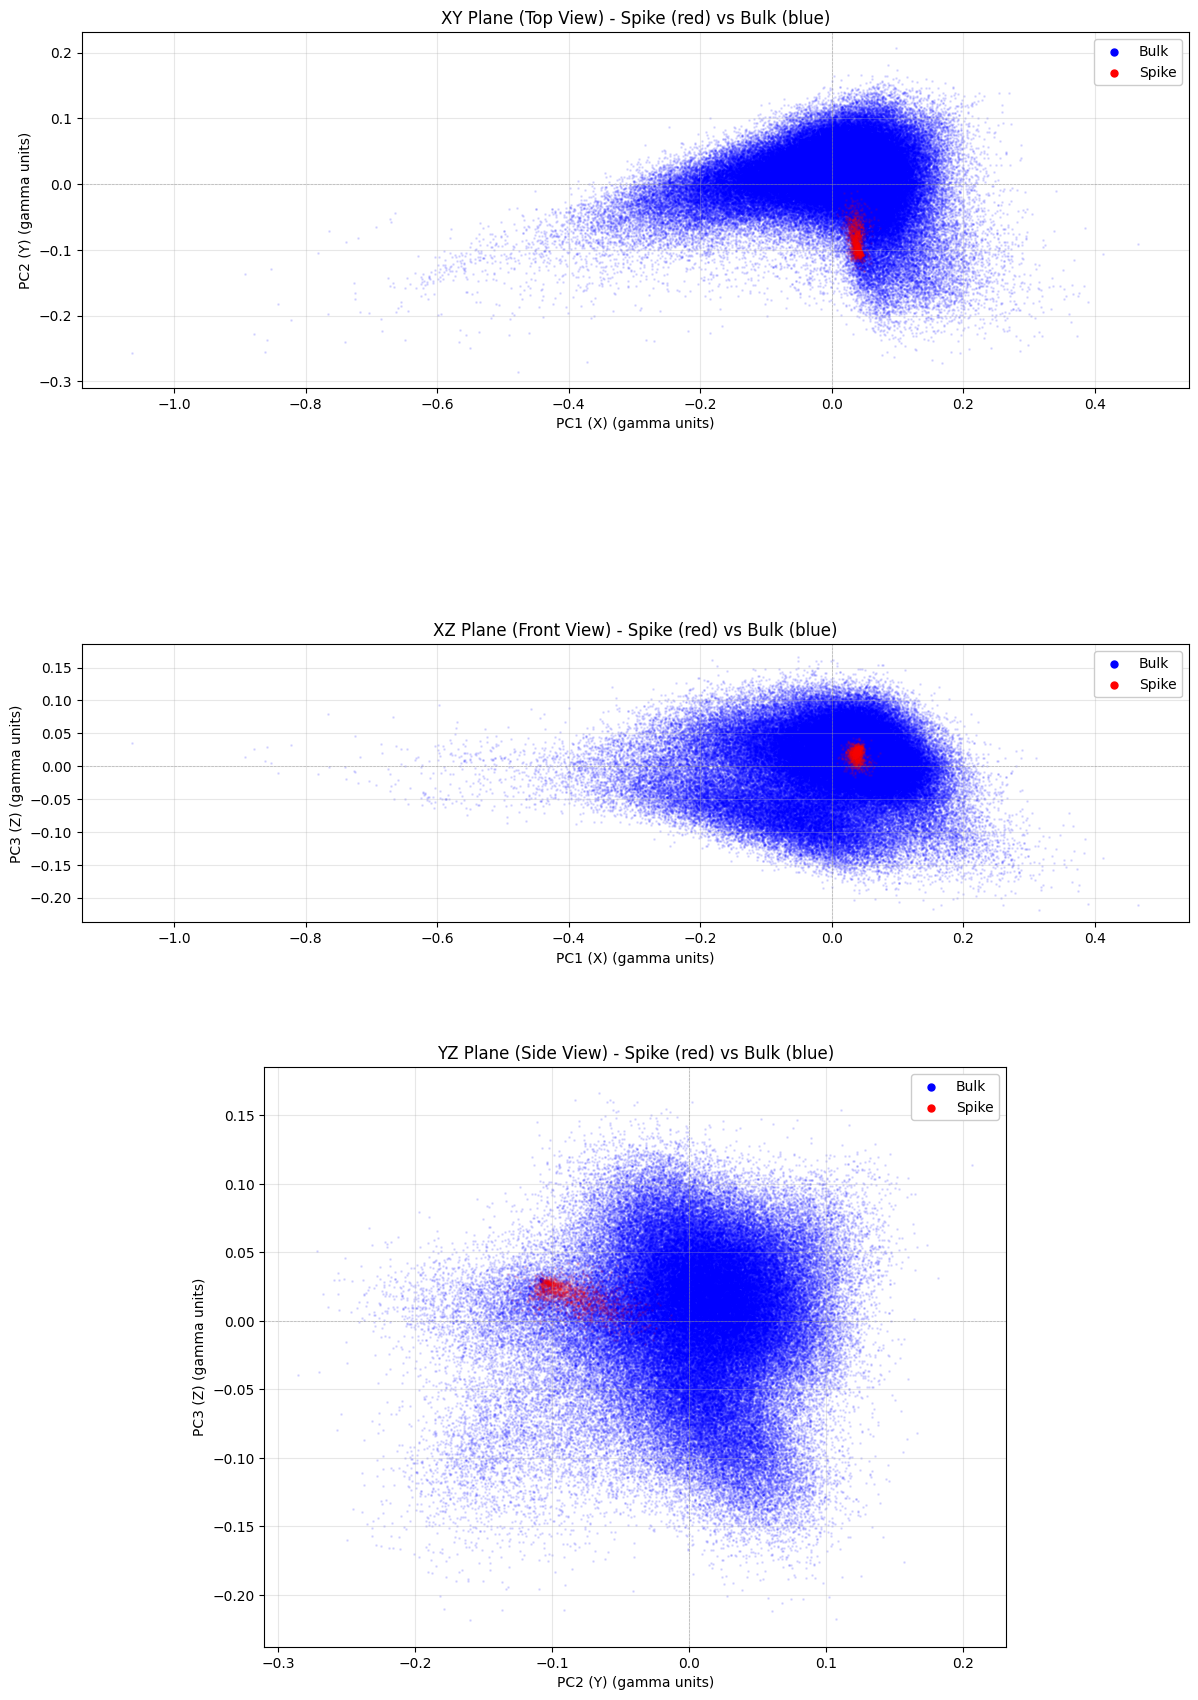


Three orthographic views of PC1 × PC2 × PC3.
Spike tokens (1,487) shown in RED.
Bulk tokens (150,449) shown in BLUE.


In [49]:
fig, axes = plt.subplots(3, 1, figsize=(12, 18), dpi=DPI)

# XY Plane (Top View) - color by spike membership
ax = axes[0]
# Plot bulk first (background)
ax.scatter(proj_X_np[~spike_mask_np], proj_Y_np[~spike_mask_np], 
           c=BULK_COLOR, s=POINT_SIZE, alpha=POINT_ALPHA, rasterized=True, label='Bulk')
# Plot spike on top (foreground)
ax.scatter(proj_X_np[spike_mask_np], proj_Y_np[spike_mask_np], 
           c=SPIKE_COLOR, s=POINT_SIZE, alpha=POINT_ALPHA, rasterized=True, label='Spike')
ax.set_xlabel(f'PC{INDEX_X} (X) (gamma units)')
ax.set_ylabel(f'PC{INDEX_Y} (Y) (gamma units)')
ax.set_title(f'XY Plane (Top View) - Spike (red) vs Bulk (blue)')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
legend = ax.legend(markerscale=5, framealpha=1.0)
# Fix legend marker alpha to be fully opaque
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

# XZ Plane (Front View) - color by spike membership
ax = axes[1]
ax.scatter(proj_X_np[~spike_mask_np], proj_Z_np[~spike_mask_np], 
           c=BULK_COLOR, s=POINT_SIZE, alpha=POINT_ALPHA, rasterized=True, label='Bulk')
ax.scatter(proj_X_np[spike_mask_np], proj_Z_np[spike_mask_np], 
           c=SPIKE_COLOR, s=POINT_SIZE, alpha=POINT_ALPHA, rasterized=True, label='Spike')
ax.set_xlabel(f'PC{INDEX_X} (X) (gamma units)')
ax.set_ylabel(f'PC{INDEX_Z} (Z) (gamma units)')
ax.set_title(f'XZ Plane (Front View) - Spike (red) vs Bulk (blue)')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
legend = ax.legend(markerscale=5, framealpha=1.0)
# Fix legend marker alpha to be fully opaque
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

# YZ Plane (Side View) - color by spike membership
ax = axes[2]
ax.scatter(proj_Y_np[~spike_mask_np], proj_Z_np[~spike_mask_np], 
           c=BULK_COLOR, s=POINT_SIZE, alpha=POINT_ALPHA, rasterized=True, label='Bulk')
ax.scatter(proj_Y_np[spike_mask_np], proj_Z_np[spike_mask_np], 
           c=SPIKE_COLOR, s=POINT_SIZE, alpha=POINT_ALPHA, rasterized=True, label='Spike')
ax.set_xlabel(f'PC{INDEX_Y} (Y) (gamma units)')
ax.set_ylabel(f'PC{INDEX_Z} (Z) (gamma units)')
ax.set_title(f'YZ Plane (Side View) - Spike (red) vs Bulk (blue)')
ax.axhline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')
legend = ax.legend(markerscale=5, framealpha=1.0)
# Fix legend marker alpha to be fully opaque
for handle in legend.legend_handles:
    handle.set_alpha(1.0)

plt.tight_layout()
plt.show()

print(f"\nThree orthographic views of PC{INDEX_X} × PC{INDEX_Y} × PC{INDEX_Z}.")
print(f"Spike tokens ({spike_mask.sum().item():,}) shown in RED.")
print(f"Bulk tokens ({(~spike_mask).sum().item():,}) shown in BLUE.")

## Summary

We've color-coded the orthographic projections by spike membership:
- **RED** = Spike tokens (1,487 initialization fossils)
- **BLUE** = Bulk tokens (150,449 trained tokens)

**Key question:** Is the mysterious "jet" we saw in PC4×5×6 space actually the spike?

If the jet lights up RED, we've found our initialization fossils!
If the jet stays BLUE, it's a different structure (maybe a semantic cluster).

**What we're testing:**
- Hypothesis: Spike tokens stayed near primordial initialization
- After bulk training displaced most tokens, centering moved the origin
- Spike now appears as a separate structure offset from bulk centroid
- This offset might be visible as the jet in certain PC projections